# Getting started with  `limlam_mocker` 

The objectives of this notebook are to present how the base parameters used in `limlam_mocker` work and show how to generate the line intensity cubes

Author: Patrick Horlaville

NOTE: 

- for supplemental information or any question you might have going through this readme, refer to https://arxiv.org/abs/2309.15733 
- or contact me at : phorlaville24@ubishops.ca

First, read this notebook from the root limCode folder, so the imports work correctly. Therefore, this whole notebook will run as though its location is:

In [1]:
%cd '/fs/lustre/scratch/horlaville/clara_limlam/limCode2020-master_clara_2/'

/fs/lustre/scratch/horlaville/clara_limlam/limCode2020-master_clara_2


Then, import all packages:

In [2]:
# base imports
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# various math package imports
import math
from scipy import special
from scipy import interpolate
import astropy.units as u 
from scipy.ndimage import gaussian_filter

# base intensity mapping package
from lim import lim 

# My plotting preferences
matplotlib.rcParams.update({'font.size': 18,'figure.figsize':[8,7]}) 
#plt.rcParams["mathtext.fontset"] = "dejavuserif"

# Dongwoo's math font plotting preferences, which I used for my paper:
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{tgheros}\\usepackage{sansmath}\\sansmath'


# used to check on the running time of particular computations
from datetime import datetime

Then, we can load the lim model. The argument of `lim()` is the model chosen in `params.py`. Each model is designed to generate intensity maps of a particular line, more particularly a cube of intensites whose voxels are distributed along each angular coordinate (right ascension (RA) and declination) as well as in frequency space, although `limlam_mocker` allows to generate other by-products, such as the one-dimensional power spectrum of the cube's intensities. In the current `params.py` file, there are lots of models available; I personally mainly worked with mine (which I iterately worked over, the final version of which is `'Lichen_v4'`, which models the [C II] line) and the Tony Li's CO model (`'TonyLi_PhI'`).

In [3]:
# Initialize LineModel with default model
m = lim()
m_cii = lim('Lichen_v4', doSim = True)

Input cosmological model does not match simulations
Setting analytic cosmology to match simulation


## Parameters' breakdown:

`m_cii` is the `lim` object out of which we will extract our intensity map. There are multiple input parameters which will define the cube of intensities:

1) `catalogue_file`: string, path to input halo lightcone 
- The most important parameter is the halo lightcone used for the simulation. The halo lightcone must contain all the information required to model the signal from all its halos (position, comoving coordinates, redshift, mass, etc.). For more information on the lightcone properties needed to be processed through `limlam_mocker`, refer to `/mnt/scratch-lustre/horlaville/nate_sims/gaussian/pksc3npz.py`, which is the example of a script that converts raw peakpatch lightcones to npz files that can be processed by `limlam_mocker`.
- For my project, I used peak-patch halo lightcones from `/home/dongwooc/scratchspace/pprun_hiz_npz/`, where there are 270 halo lightcones in the $z \approx$ [5.8, 7.9] redshift range and with $\approx$ 4 deg$^2$ angular size.

2) `model_name`: string, label of the mass-luminosity function
- The second most important parameter is the mass-luminosity function used for the simulation. For mass-luminosity functions, choose a function from `mass_luminosity.py`. It determines the intensity map's line model. 
- Personally, I used `model_name='LichenCII_v3'` for my latest [C II] model, which includes the H I + metallicity dependence as well as metallicity scatter.

3) `model_type`: string, luminosity prescription model type
- The model type depends on the prescription used to generate the halo luminosities (as defined by `model_name`). If the luminosity prescription uses a halo-mass function (as can be found in `mass_luminosity.py`), then use `model_type='ML'`. If it uses a luminosity function (as can be found in `luminosity_functions.py`), then use `model_type='LF'`.
- For example, in my case, I use a halo-mass relationship (with `model_name='LichenCII_v3'`), so I use `model_type='ML'`.

4) `model_par`: dictionary, parameters for `model_name`
- There are typically plenty of parameters prescribed inside the mass-luminosity function, some of which can be assigned in `model_par`. Typically, for relative entropy analysis, those are the fiducial values to be modified. The idea is to modify them a bit and analyze how much their variation affects the simulation results. 

Cube parameters in frequency (perpendicular) space:

5) `nu`: astropy quantity, restframe frequency of the line
- `nu` has to be set to the restframe frequency of the line prescribed from the chosen mass-luminosity function. 
- In my case, since my mass-luminosity function targets [C II], `nu` is set to $\nu_{[\rm{C\ II}],\ rest}$, which is 1897GHz.

6) `nuObs`: astropy quantity, median observed frequency for the cube of intensities
- `nuObs` is the central observed frequency for the simulation. If the lightcone's halos span redshift [$z_0$, $z_f$], such that the median redshift is $z_{\rm{med}} = (z_0 + z_f)/2$, then `nuObs` would typically be set to `nu`/(1 + $z_{\rm{med}}$).
- For example, in my case, I used halo lightcones in the redshift range $z \approx$ [5.8, 7.9], but I mainly worked in the redshift range $z \approx$ [5.6, 6.6], such that $z_{\rm{med}} \approx$ 6.1; so I set `nuObs` to 1897 GHz/(1 + 6.1) $\approx$ 270 GHz.

7) `Delta_nu`: astropy quantity, frequency span of the cube
- The halo lightcone spanning [$z_0$, $z_f$] in redshift space, what's the span in frequency space? That would be $\nu_{\rm{max}} - \nu_{\rm{min}}$, where the maximum frequency is attained at the minimum redshift: $\nu_{\rm{max}}$ =`nu`$/(1+z_0)$ and vice-versa: $\nu_{\rm{min}}$ = `nu`/$(1+z_f)$. If we want our cube of intensities to span the frequency range of our halo lightcone, which is typically the case, we just set `Delta_nu` to $\nu_{\rm{max}} - \nu_{\rm{min}}$. 
- In my case, I mainly worked in the $z \approx$ [5.6, 6.6] redshift range, which corresponds to $\nu \approx$ [250, 290] GHz. Therefore, I set `Delta_nu` to 290-250 = 40 GHz.

8) `dnu`: astropy quantity, frequency channelization
- Each frequency slice of the cube of intensities will be separated by `dnu`. Its value is usually chosen in accordance to the frequency resolution abilities of typical observational instruments aiming the observation of the desired line. 
- For example, for my project, I ran all of my analysis using the CCAT deep spectroscopic survey (CCAT-DSS) osbervational characteristics, whose expected frequency channelization should be around 2.8GHz. Since I had set `Delta_nu` to 40 GHz, this means my cube of intensities will have 40 GHz/2.8GHz $\approx$ 15 frequency channels.

NOTE:

- For sharper band analysis, `Delta_nu` can be smaller than $\nu_{\rm{max}} - \nu_{\rm{min}}$. Also, `nuObs` can be set to any value between $\nu_{\rm{min}}$ and $\nu_{\rm{min}}$, but `Delta_nu` should be chosen so that `nuObs` + `Delta_nu`/2 < $\nu_{\rm{max}}$ and `nuObs` - `Delta_nu`/2 > $\nu_{\rm{min}}$. In other words, it's important to generate a cube of intensities whose frequency span is within the frequency span of the halo lightcone. Otherwise, some of the cube's frequency channels may be empty.

Cube parameters in angular (parallel) space:

9) `Omega_field`: astropy quantity, angular area coverage
- `Omega_field` is the angular area coverage, in the sky, of the cube. My typical process to find it from scratch is to use the halo lightcone's comoving radial distance and perpendicular size, say $\chi_r$ and $\chi_\perp$. I approximate the angular size of the halo lightcone with $\rm{tan}(\theta) \sim \frac{\chi_\perp}{\chi_r}$, such that $\theta \sim \rm{arctan}(\frac{\chi_\perp}{\chi_r})$. Then, set `Omega_field` $\sim \theta^2$. Note that I advise to round down `Omega_field` rather than up as it is better to have a cube of intensities full of halos rather than to have the cube's edges missing halos because the angular size is slightly larger than the one from the lightcone. Note also that any value below $\theta^2$ can also be used, as it will just consider a smaller portion of the lightcone.
- The lightcones I used for my project have an angular area coverage of 4 deg$^2$, so I set `Omega_field` to 4 deg$^2$.

Observational instrument-related parameters:

10) `tobs`: astropy quantity, observing time
- `tobs` defines the total observing time of the observational survey forecast per angular area coverage (`Omega_field`) across all spectroscopic feeds and voxels. 
- For example, for my project, I used two base values for `tobs` corresponding to 2 different observational scenarios for CCAT-DSS: 2000h and 40000h.

11) `Tsys_NEFD`: astropy quantity, noise equivalent flux density
- `Tsys_NEFD` is the noise equivalent flux density, which is the noise per instrumental beam. 
- For example, for my CCAT-DSS forecast, I used `Tsys_NEFD` = 72.5 mJy s$^{1/2}$, which means that a source recorded to have an intensity of 72.5 mJy through a single spectrometer with one second of observation would be detected with a signal-to-noise ratio (SNR) of 1.

12) `beam_FWHM`: astropy quantity, beam's full width at half max
- This parameter is simply the beam's full width at half maximum. 
- For my CCAT-DDS forecast, I used `beam_FWHM` = 48 arcseconds, which implies a beam width of ($\sqrt{8ln\ 2})^{-1} \times$ `beam_FWHM` $\approx$ 20 arcseconds. Given each angular slice of the cube has an area of 4 deg$^2$, which means an angular size of 2 deg (= 7200 arcseconds), the cube will generate $\approx$ 7200/20 = 360 pixels in angular resolution. Since we also have 15 frequency channels, this means that our cube of intensities will be (360 x 360 x 15) in size, in both angular and frequency dimension respectively.

13) `Nfeeds`: integer, number of feeds
- This corresponds to the number of spectroscopic feeds of the observational instrument.
- For example, for the CCAT-DSS forecast, I set `Nfeeds` = 120.

14) `Nfield`: integer, number of fields
- This corresponds to the number of fields to be observed by the observational instrument.
- For example, for the CCAT-DSS forecast, I set `Nfield` = 4.

Other parameters:

15) `Mmin` & `Mmax`: astropy quantity, minimum and maximum halo masses
- The code will ignore all the halos in the lightcone whose masses are inferior to `Mmin` or superior to `Mmax`.

Note that if those parameters are not specified, the default ones in `params.py` will be used. It's therefore important to make sure that all the parameters used for the simulation are the adequate and desired ones. The `lim` object has a convenient function, `update`, which allows to update its parameters. I typically always use this function to set all the important parameters:

In [4]:
m_cii.update(model_par = {'zdex': 0.4,
 'M0': 1900000000.0,
 'Mmin': 20000000000,
 'alpha_MH1': 0.74,
 'alpha_LCII': 0.024,
 'alpha0': -1.412,
 'gamma0': 0.31,
 'BehrooziFile': 'sfr_reinterp.dat'},
            dnu = 2.8*u.GHz,
            nuObs = 270*u.GHz,
            Delta_nu = 40*u.GHz,
            tobs = 40000*u.h,
            Omega_field = 4*u.deg**2,
            catalogue_file = '/home/dongwooc/scratchspace/pprun_hiz_npz/COMAP_z5.8-7.9_960Mpc_seed_13819.npz')

Our parameters are all set! We can start loading base outputs from `limlam_mocker`, the most important of which being the cube of intensities. What does our cube of intensities look like?

The object `m_cii` is a dictionnary that contains a multitude of elements that can be called with the appropriate command. Listing all of them would take an eternity, but you can browse them by hitting `m_cii.` + tabulation key. Let's focus on the most important ones:

1) Cube of intensities, `m_cii.maps`

In [5]:
cii_cube = m_cii.maps

Loading .npz catalogues...


This step typically takes $\approx$ 2 minutes for my model. It loads all of the voxels' intensities. Loading all the remaining items in `m_cii` won't take nearly as much time.

You can check that the shape of your cube matches what you expected from your parameters:

In [6]:
np.shape(cii_cube) # RA, dec and frequency axes' resolution respectively

(354, 354, 15)

You can retrieve the redshift of each cube's slice:

In [7]:
cube_zs = (m_cii.mapinst.nu_rest/m_cii.mapinst.nu_bincents) - 1
cube_zs

array([5.57376238, 5.6395    , 5.70656566, 5.775     , 5.84484536,
       5.91614583, 5.98894737, 6.06329787, 6.13924731, 6.21684783,
       6.29615385, 6.37722222, 6.46011236, 6.54488636, 6.6316092 ])

And select, for example, the RA/dec slice that you want to display. Here, I want to show a slice at redshift 6, so I select the 7th frequency slice. I also select an intensity cut off of 2000 Jy/sr, since the contrast between the brightest and the dimmest pixels will render the map seemingly empty otherwise:

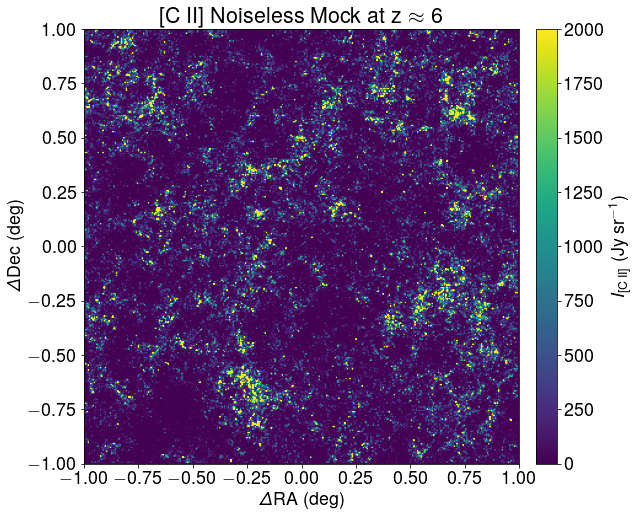

In [8]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 8))

plt.subplot(111)
plt.imshow(cii_cube[:, :, 6], vmax = 2000, cmap =  'viridis', extent = [-1, 1, -1, 1], rasterized = True)
plt.title('[C II] Noiseless Mock at z $\\approx$ 6')
plt.ylabel('$\\Delta$Dec (deg)')
plt.xlabel('$\\Delta$RA (deg)')
plt.colorbar(label = '$I_{\\rm [C\\, II]}$ (Jy sr$^{-1}$)', pad = 0.03)

Note that the `maps` object is the pure line signal, with no beam or noise added. To mock the pure signal observed with a certain beam size and no noise, you can apply a Gaussian filter of the size of 1 pixel:

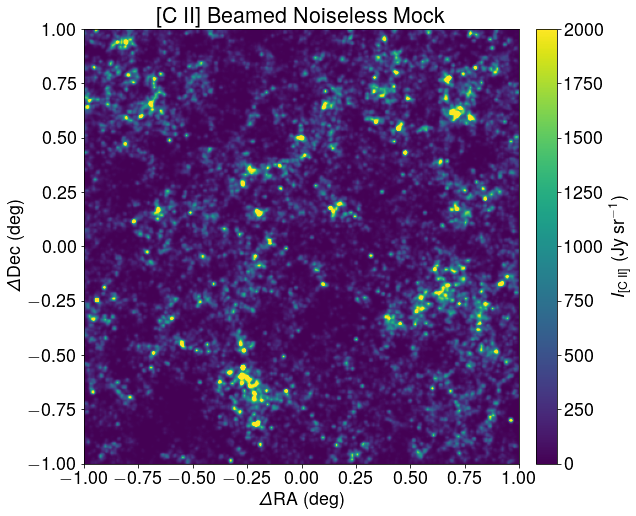

In [9]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 8))

plt.subplot(111)
plt.imshow(gaussian_filter(cii_cube[:, :, 6], 1), vmax = 2000, cmap =  'viridis', extent = [-1, 1, -1, 1], rasterized = True)
plt.title('[C II] Beamed Noiseless Mock')
plt.ylabel('$\\Delta$Dec (deg)')
plt.xlabel('$\\Delta$RA (deg)')
plt.colorbar(label = '$I_{\\rm [C\\, II]}$ (Jy sr$^{-1}$)', pad = 0.03)

However, if need be to convolve the signal with a different beam size, then you can use this function to find the number of pixel to use in the Gaussian filtering function:

In [10]:
def pix_res(m, beam_width = m.beam_width, map_dim_pix = m.Nside, map_dim_deg = np.sqrt(m.Omega_field)):
    
    '''
    Computes the pixel size corresponding to beaming the signal with a certain angle (beam_width) 
    given the size of the map in degrees (map_dim_deg) and in pixels (map_dim_pix) 
    
    Parameters
    ----------
    
    beam_width : astropy quantity
                 Angular size of the beam to be convolved with the signal
                 If set to the default 'beam_width' (which is equal to 'beam_FWHM'/sqrt(8ln(2))), pix_res should be 1 pixel 
    
    map_dim_pix: astropy quantity
                 Size of the map (in pixels) in the angular (RA/dec) plane
                 Default should be set to 'Nside'
    
    map_dim_deg: astropy quantity
                 Angular size of the map
                 Default should be set to sqrt('Omega_field')
    
    '''
        
    return int(round((beam_width.to(u.arcmin)/((map_dim_deg.to(u.arcmin)/map_dim_pix))).value, 0))

So, by default, the pixelization is 1 pixel in size:

In [11]:
pix_res(m_cii)

1

But if we want to beam the signal with a 1' beam width, then that pixelization becomes:

In [12]:
pix_res(m_cii, beam_width = 1*u.arcmin, map_dim_pix = m_cii.Nside, map_dim_deg = np.sqrt(m_cii.Omega_field))

3

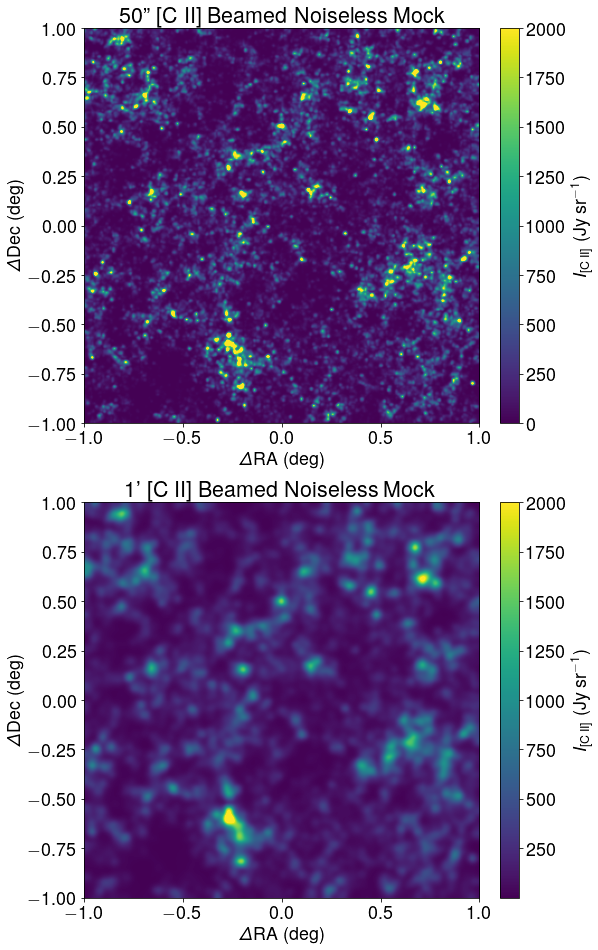

In [13]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 16))

plt.subplot(211)
plt.imshow(gaussian_filter(cii_cube[:, :, 6], 1), vmax = 2000, cmap =  'viridis', extent = [-1, 1, -1, 1], rasterized = True)
plt.title('50" [C II] Beamed Noiseless Mock')
plt.ylabel('$\\Delta$Dec (deg)')
plt.xlabel('$\\Delta$RA (deg)')
plt.colorbar(label = '$I_{\\rm [C\\, II]}$ (Jy sr$^{-1}$)', pad = 0.03)

plt.subplot(212)
plt.imshow(gaussian_filter(cii_cube[:, :, 6], 3), vmax = 2000, cmap =  'viridis', extent = [-1, 1, -1, 1], rasterized = True)
plt.title("1' [C II] Beamed Noiseless Mock")
plt.ylabel('$\\Delta$Dec (deg)')
plt.xlabel('$\\Delta$RA (deg)')
plt.colorbar(label = '$I_{\\rm [C\\, II]}$ (Jy sr$^{-1}$)', pad = 0.03)

2) Cube of intensities convolved with the beam + noise, `m_cii.noise_added_map`

The cube of intensities generated with `m_cii.maps` is the pure signal with no noise. We can also look at the cube of intensities with Gaussian noise injected on top of the pure signal with `m_cii.noise_added_map`. For more information on the noise modeling, refer to my paper at $\S$3.2.

In [14]:
cii_noise = m_cii.noise_added_map

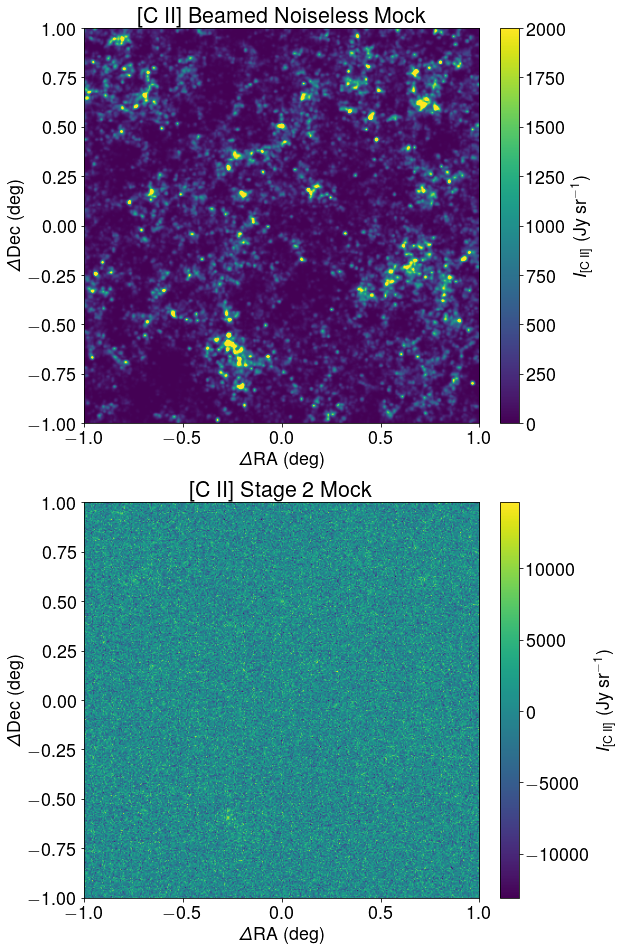

In [15]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12, 16))

plt.subplot(211)
plt.imshow(gaussian_filter(cii_cube[:, :, 6], 1), vmax = 2000, cmap =  'viridis', extent = [-1, 1, -1, 1], rasterized = True)
plt.title('[C II] Beamed Noiseless Mock')
plt.ylabel('$\\Delta$Dec (deg)')
plt.xlabel('$\\Delta$RA (deg)')
plt.colorbar(label = '$I_{\\rm [C\\, II]}$ (Jy sr$^{-1}$)', pad = 0.03)

plt.subplot(212)
plt.imshow(cii_noise[:, :, 6], cmap =  'viridis', extent = [-1, 1, -1, 1], rasterized = True)
plt.title('[C II] Stage 2 Mock')
plt.ylabel('$\\Delta$Dec (deg)')
plt.xlabel('$\\Delta$RA (deg)')
plt.colorbar(label = '$I_{\\rm [C\\, II]}$ (Jy sr$^{-1}$)', pad = 0.03)

Beyound visualization, there are a lot of statistical tools that can provide much more insight on the simulated line intensity signal and/or the simulation model itself, such as the Wiener filtering, the halo-stacked signal or the signal's distribution relative entropy variations. Here, I'll explain how I performed those analyses with `limlam_mocker`, but I will refer you once more to my paper for more in-depth explanations.